Book Recommender System


In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score


In [2]:
#reading the files
books = pd.read_csv('data/books.csv', encoding = "ISO-8859-1")
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
books.shape

(10000, 23)

The books table has 10,000 observations and 23 columns.

In [4]:
book_tags = pd.read_csv('data/book_tags.csv', encoding = "ISO-8859-1")
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [5]:
book_tags.shape

(999912, 3)

The book tags table has 999912 observations and 3 columns

In [9]:
ratings = pd.read_csv('data/ratings.csv', encoding = "ISO-8859-1")
ratings.head()


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [10]:
ratings.shape

(981756, 3)

In [11]:
tags = pd.read_csv('data/tags.csv', encoding = "ISO-8859-1")
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [12]:
tags.shape

(34252, 2)

The tags table has 34252 rows and 2 columns

In [13]:
to_read = pd.read_csv('data/to_read.csv', encoding = "ISO-8859-1")
to_read.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [14]:
to_read.shape

(912705, 2)

The table to_read has 912705 observations and 2 columns

## Exploratory data analysis
Let's see various distributions of the data
1. Missing values

In [15]:
books.isna().mean()

id                           0.0000
book_id                      0.0000
best_book_id                 0.0000
work_id                      0.0000
books_count                  0.0000
isbn                         0.0700
isbn13                       0.0585
authors                      0.0000
original_publication_year    0.0021
original_title               0.0585
title                        0.0000
language_code                0.1084
average_rating               0.0000
ratings_count                0.0000
work_ratings_count           0.0000
work_text_reviews_count      0.0000
ratings_1                    0.0000
ratings_2                    0.0000
ratings_3                    0.0000
ratings_4                    0.0000
ratings_5                    0.0000
image_url                    0.0000
small_image_url              0.0000
dtype: float64

Language code, isbn and original title have missing values. We can drop rows where original title is missing

In [16]:
book_tags.isna().mean()

goodreads_book_id    0.0
tag_id               0.0
count                0.0
dtype: float64

In [17]:
ratings.isna().mean()

book_id    0.0
user_id    0.0
rating     0.0
dtype: float64

In [18]:
tags.isna().mean()

tag_id      0.0
tag_name    0.0
dtype: float64

In [19]:
to_read.isna().mean()

user_id    0.0
book_id    0.0
dtype: float64

Rest of the tables do nto have any missing values. Let's also remove the duplicate values.

In [20]:
ratings.drop_duplicates(subset =["user_id","book_id"], 
                     keep = False, inplace = True) 
ratings.shape

(977269, 3)

 4487 duplicates were removed

In [21]:
print(books.shape)
books.drop_duplicates(subset='original_title',keep=False,inplace=True)
print(books.shape)

(10000, 23)
(9151, 23)


849 rows removed.

In [22]:
print(tags.shape)
tags.drop_duplicates(subset='tag_id',keep=False,inplace=True)
print(tags.shape)

(34252, 2)
(34252, 2)


There are no duplicates in tags.

In [23]:
print(book_tags.shape)
book_tags.drop_duplicates(subset=['tag_id','goodreads_book_id'],keep=False,inplace=True)
print(book_tags.shape)

(999912, 3)
(999896, 3)


### Visualization

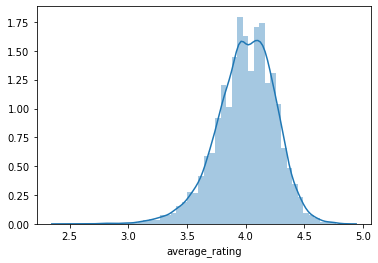

In [24]:
sns.distplot(a=books['average_rating'], kde=True);

Most of the average ratings fall between 3.5-4.5

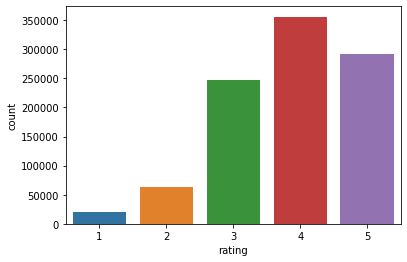

In [25]:
fig=sns.countplot(x=ratings['rating']);

Most of the ratings fall between 3-5

In [26]:
top_rated=books.sort_values('average_rating', ascending=False)
top10=top_rated.head(10)
f=['title','small_image_url']
displ=(top10[f])
displ.set_index('title', inplace=True)

In [27]:
import pandas as pd
from IPython.display import Image, HTML

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'
pd.set_option('display.max_colwidth', -1)
HTML(displ.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html)))

,small_image_url
title,
The Complete Calvin and Hobbes,
"Words of Radiance (The Stormlight Archive, #2)",
Mark of the Lion Trilogy,
It's a Magical World: A Calvin and Hobbes Collection,
There's Treasure Everywhere: A Calvin and Hobbes Collection,
"Harry Potter Boxset (Harry Potter, #1-7)",
"Harry Potter Collection (Harry Potter, #1-6)",
The Indispensable Calvin and Hobbes,
The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury,


Top 10 rated books

In [28]:
most_pop=books.sort_values('ratings_count', ascending=False)
pop10=most_pop.head(10)
f=['title','small_image_url']
displ1=(pop10[f])
displ1.set_index('title', inplace=True)

In [29]:
import pandas as pd
from IPython.display import Image, HTML

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'
pd.set_option('display.max_colwidth', -1)
HTML(displ1.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html)))

,small_image_url
title,
"The Hunger Games (The Hunger Games, #1)",
"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
To Kill a Mockingbird,
The Great Gatsby,
The Fault in Our Stars,
The Hobbit,
The Catcher in the Rye,
Pride and Prejudice,
"Angels & Demons (Robert Langdon, #1)",


Top 10 most popular books by ratings

In [30]:
authors=books.groupby('authors').agg({'average_rating':'mean','ratings_count':'sum'}).reset_index()
top_rated_authors=authors.sort_values('average_rating', ascending=False).head(10)[['authors','average_rating']]
most_pop_authors=authors.sort_values('ratings_count', ascending=False).head(10)[['authors','ratings_count']]

C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0, flags=flags)


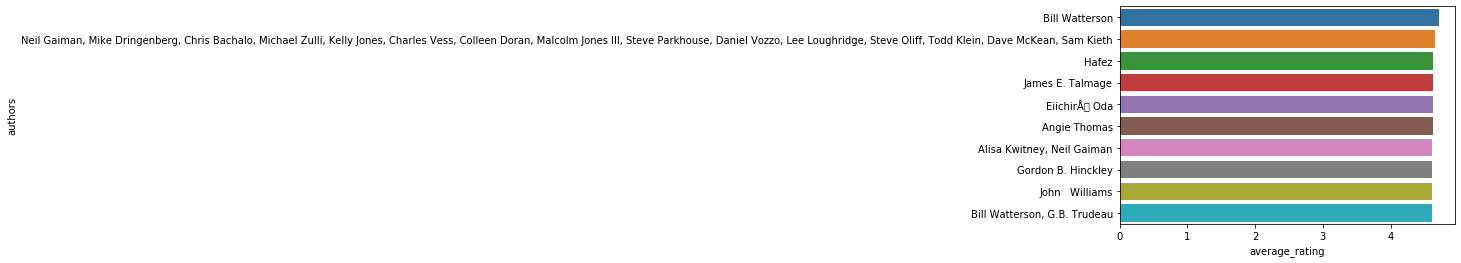

In [31]:
sns.barplot(data=top_rated_authors,x='average_rating',y='authors');

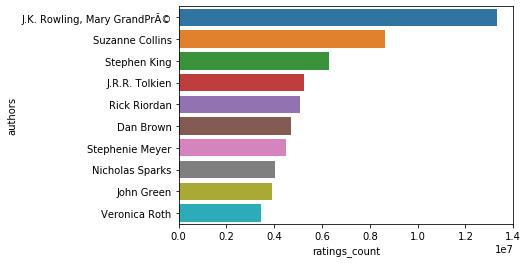

In [32]:
sns.barplot(data=most_pop_authors,x='ratings_count',y='authors');


Number of ratings per user

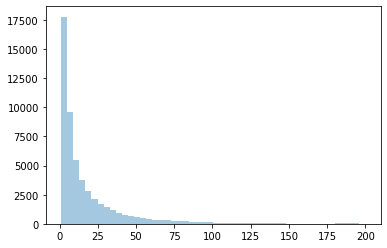

In [33]:
sns.distplot(ratings.groupby('user_id').agg({'rating':'count'}),kde=False)

Number of ratings per book

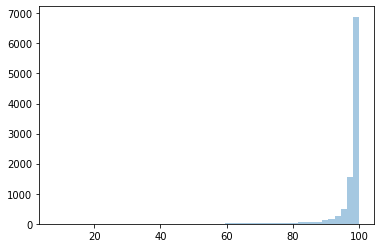

In [34]:
sns.distplot(ratings.groupby('book_id').agg({'rating':'count'}),kde=False);

Let's explore which genres are more famous

In [35]:
genres=["Art", "Biography", "Business", "Chick Lit", "Children's", "Christian", "Classics", "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction", "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror", "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal", "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction", "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]
for i in range(len(genres)):
    genres[i]=genres[i].lower()

In [44]:
joint_tag=tags.merge(book_tags,on='tag_id',how='inner')
p=joint_tag.groupby('tag_name').count()
p=p.sort_values(by='count', ascending=False)

,tag_id,goodreads_book_id,count
tag_name,,,
to-read,9983,9983,9983
favorites,9881,9881,9881
owned,9856,9856,9856
books-i-own,9799,9799,9799
currently-reading,9776,9776,9776
library,9415,9415,9415
owned-books,9221,9221,9221
fiction,9097,9097,9097
to-buy,8692,8692,8692


In [65]:
new_tags=p[p.index.isin(genres)]
#new_tags.reset_index()

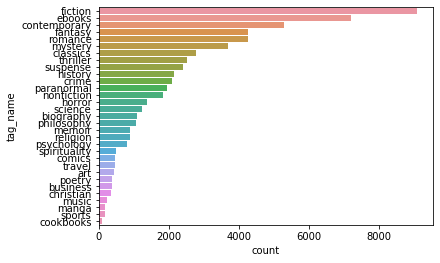

In [67]:

sns.barplot(x="count", y=new_tags.index,   data=new_tags);


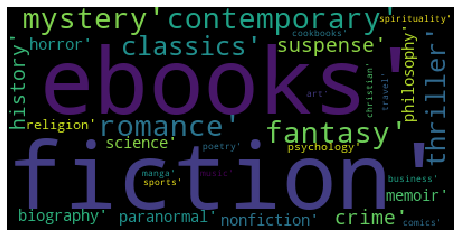

In [68]:
from wordcloud import WordCloud, STOPWORDS 
text = new_tags.index.values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##Re